# Dense sequences II

In [61]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from connectivity_functions import create_matrix_from_sequences_representation, produce_overlaped_sequences
from connectivity_functions import create_matrix_from_sequences_representation_aditive
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings, calculate_recall_success_nr

epsilon = 10e-80

## An example

In [105]:
%%time

always_learning = False
strict_maximum = True
perfect = True
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
tau_a = 0.250
g_beta = 0.0
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
mixed_start = False
contiguous = True
remove = 0.010
s = 1.0
r = 0.25
extension = n_patterns

# Recall
T_cue = 0.020
T_recall = 1.0
T_persistence = 0.050
T_recall = T_cue + (1.5) * T_persistence * n_patterns 
# T_persistence = max(0.005, T_persistence - tau_m)

factor = 0.00

# Neural Network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  g_beta=g_beta, z_transfer=z_transfer, diagonal_zero=diagonal_zero, 
                  strict_maximum=strict_maximum, perfect=perfect, k_perfect=k_perfect, 
                  always_learning=always_learning, normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
seq = np.copy(matrix)
seq[4] = matrix[2]
seq[5:] = matrix[4:-1]

n_connections = len(seq) - 1
nr = build_network_representation(matrix, minicolumns, hypercolumns)

value = 1.0
B = 1 - np.exp(-T_persistence / tau_a)
alpha = B
# g_a = g_w_ampa * alpha / B
nn.g_a = g_a
weights = [value for i in range(n_connections)]
weights_collection = [weights]
sequences = [seq]
w = create_matrix_from_sequences_representation_aditive(minicolumns, hypercolumns, sequences, weights_collection,
                                                        extension, alpha, w_min=-10)
    
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

nn.w_ampa = w
w_diff = 2 * alpha
current = 2  * g_w_ampa * w_diff
noise = factor * current
nn.sigma = noise

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 639 µs


In [106]:
w_artificial = np.copy(w)

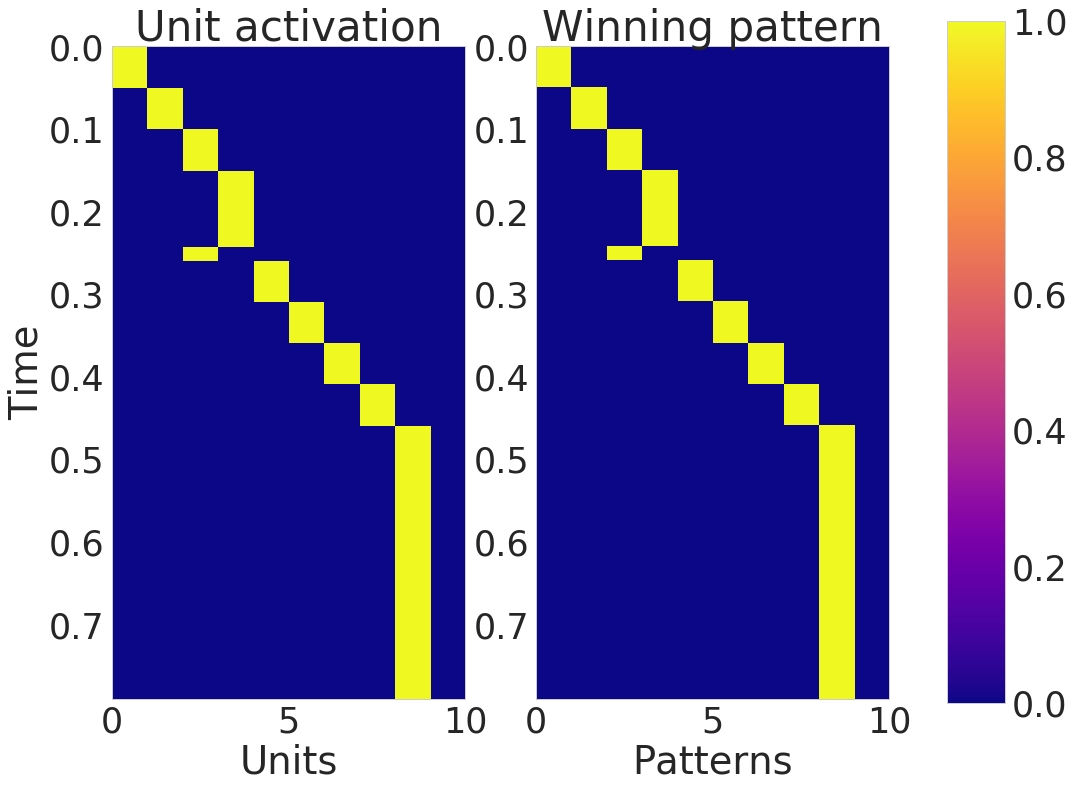

In [107]:
aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
s, timings, pattern_sequence = aux
plot_network_activity_angle(manager)

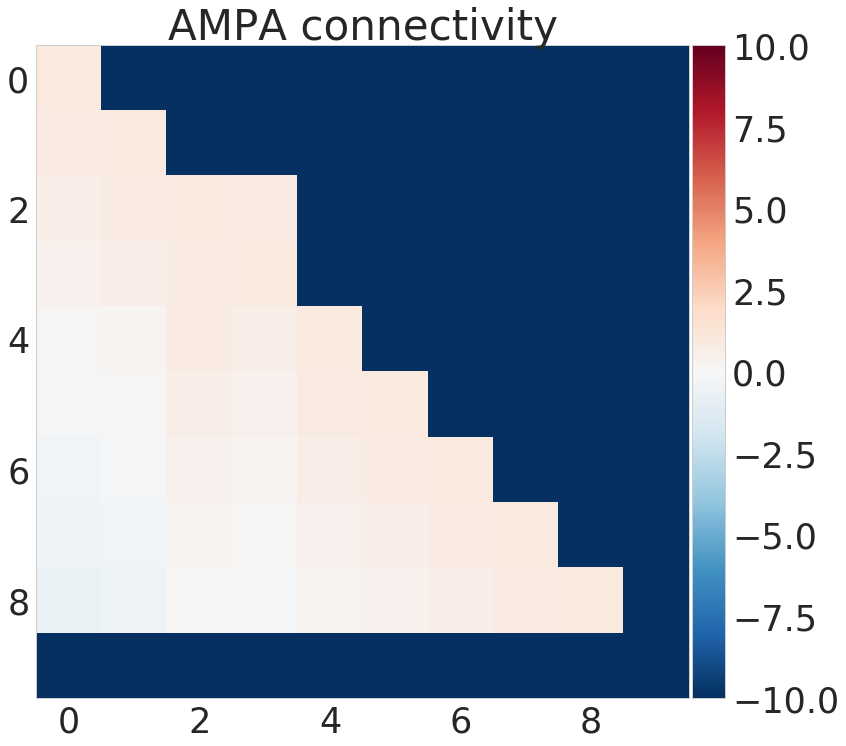

In [108]:
plot_weight_matrix(nn, ampa=True)

In [109]:
seq

array([[0],
       [1],
       [2],
       [3],
       [2],
       [4],
       [5],
       [6],
       [7],
       [8]])

In [110]:
pattern_sequence

[0, 1, 2, 3, 2, 4, 5, 6, 7, 8]

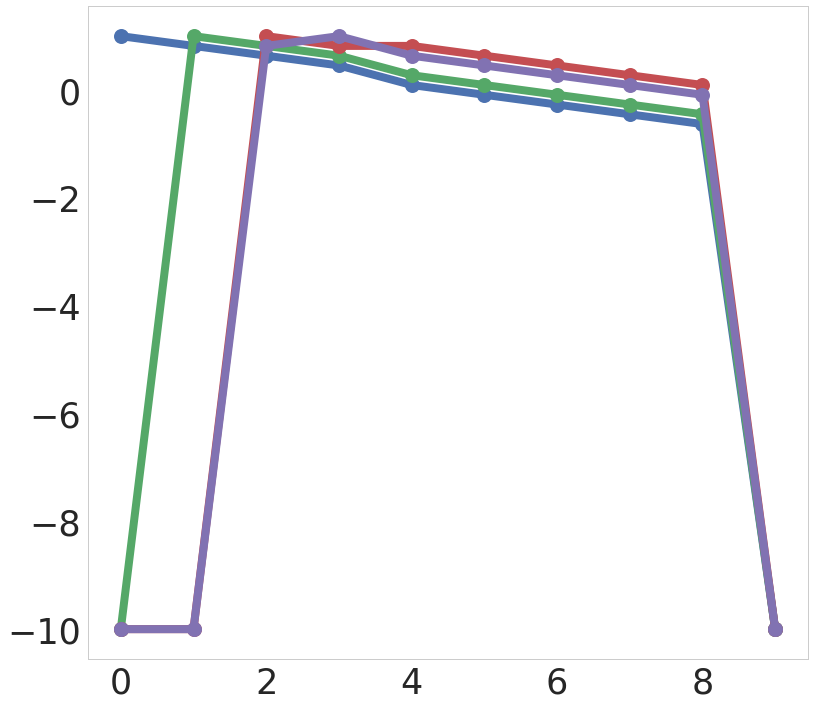

In [111]:
plt.plot(w[:, 0], 'o-', ms=15, lw=8)
plt.plot(w[:, 1], 'o-', ms=15, lw=8)
plt.plot(w[:, 2], 'o-', ms=15, lw=8)
plt.plot(w[:, 3], 'o-', ms=15, lw=8)

In [112]:
B = np.zeros((minicolumns, minicolumns))
for i in range(minicolumns):
    for j in range(minicolumns):
        B[i, j] = w[j, j] - w[i, j]

B *= (g_w_ampa / g_a)
transitions = np.copy(B)
transitions[transitions >= 1.0] = 0.0

T = tau_a * np.log(1.0 / (1 - transitions))

T_recharge = tau_a * np.log((1 + B[3, 2]) /(1 - B[2, 3]))
T_recharge

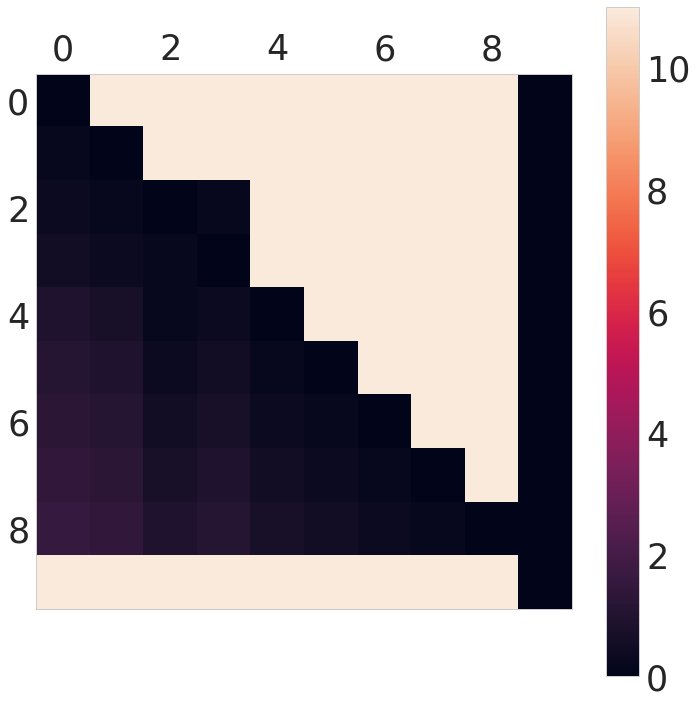

In [113]:
plt.matshow(B)
plt.colorbar()

In [114]:
timings

[(0, 0.050000000000000003, 0.0, 0.049000000000000002),
 (1, 0.051000000000000004, 0.049000000000000002, 0.099000000000000005),
 (2, 0.051000000000000004, 0.099000000000000005, 0.14899999999999999),
 (3, 0.092999999999999999, 0.14899999999999999, 0.24099999999999999),
 (2, 0.018000000000000002, 0.24099999999999999, 0.25800000000000001),
 (4, 0.051000000000000004, 0.25800000000000001, 0.308),
 (5, 0.051000000000000004, 0.308, 0.35799999999999998),
 (6, 0.051000000000000004, 0.35799999999999998, 0.40800000000000003),
 (7, 0.051000000000000004, 0.40800000000000003, 0.45800000000000002),
 (8, 0.33200000000000002, 0.45800000000000002, 0.78900000000000003)]

In [115]:
T_recharge = tau_a * np.log((1 + B[3, 2]) /(1 - B[2, 3]))
T_recharge

0.091647373345918062

In [116]:
T[4, 3]

0.11256534656827538

In [117]:
for i in range(minicolumns - 1):
    print(T[i +1, i])

0.05
0.05
0.05
0.112565346568
0.05
0.05
0.05
0.05
0.0


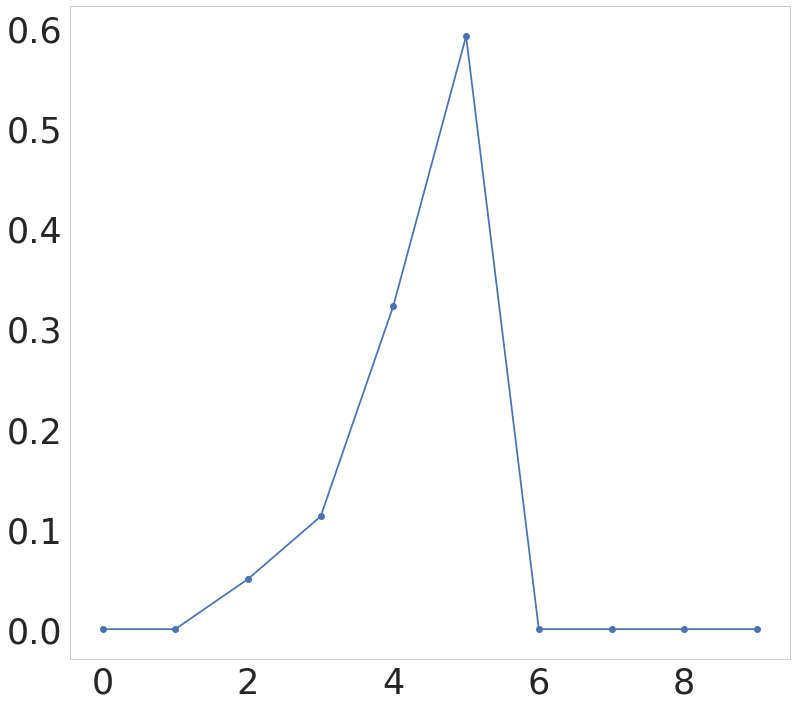

In [118]:
plt.plot(T[:, 1], 'o-')

In [119]:
B[3, 2]

0.18126924692201818

In [104]:
B[2, 3]

0.18126924692201818

## An example with training

In [40]:
always_learning = False
strict_maximum = True
perfect = True
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 1.0
T_cue = 0.020
T_persistence = 0.100
T_recall = T_cue + (1.5) * T_persistence * n_patterns 
# T_persistence = max(0.005, T_persistence - tau_m)

factor = 0.00


# Patterns parameters
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, g_beta=g_beta,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Training
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
seq = np.copy(matrix)
seq[4] = matrix[2]
seq[5:] = matrix[4:-1]

nr = build_network_representation(seq, minicolumns, hypercolumns)
timed_input = TimedInput(nr, dt, training_time, 
                         inter_pulse_interval=inter_pulse_interval, 
                         inter_sequence_interval=inter_sequence_interval, 
                         epochs=epochs, resting_time=resting_time)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
w, beta = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

nn.w_ampa = w
nn.beta = beta

# Fix the persistence time
B = 1 - np.exp(-T_persistence / tau_a)
w_per = w[7, 7] - w[8, 7]
g_a = g_w_ampa * w_per / B
nn.g_a = g_a

w_rob = w[1, 1] - w[3, 1]
current = 2  * g_w_ampa * w_rob
noise = factor * current
nn.sigma = noise

# Dictionary
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

1.0


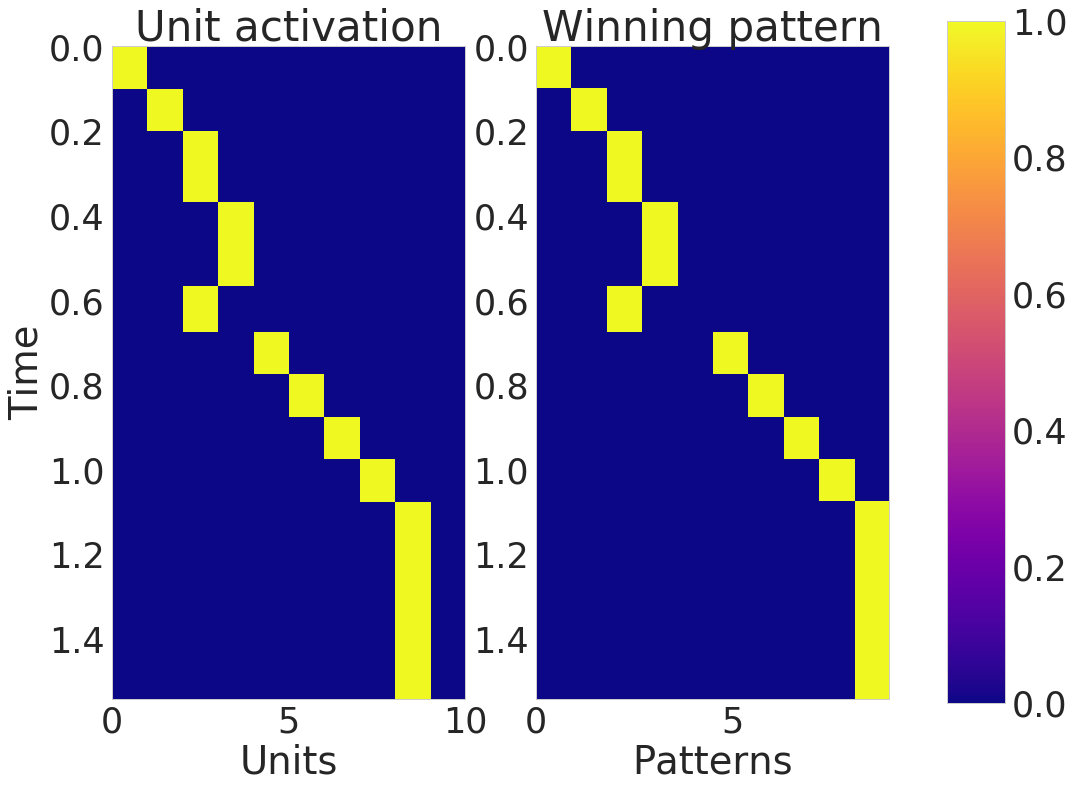

In [41]:
aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
s, timings, pattern_sequence = aux
print(s)
plot_network_activity_angle(manager)

In [42]:
seq

array([[0],
       [1],
       [2],
       [3],
       [2],
       [4],
       [5],
       [6],
       [7],
       [8]])

In [43]:
pattern_sequence

[0, 1, 2, 3, 2, 5, 6, 7, 8, 9]

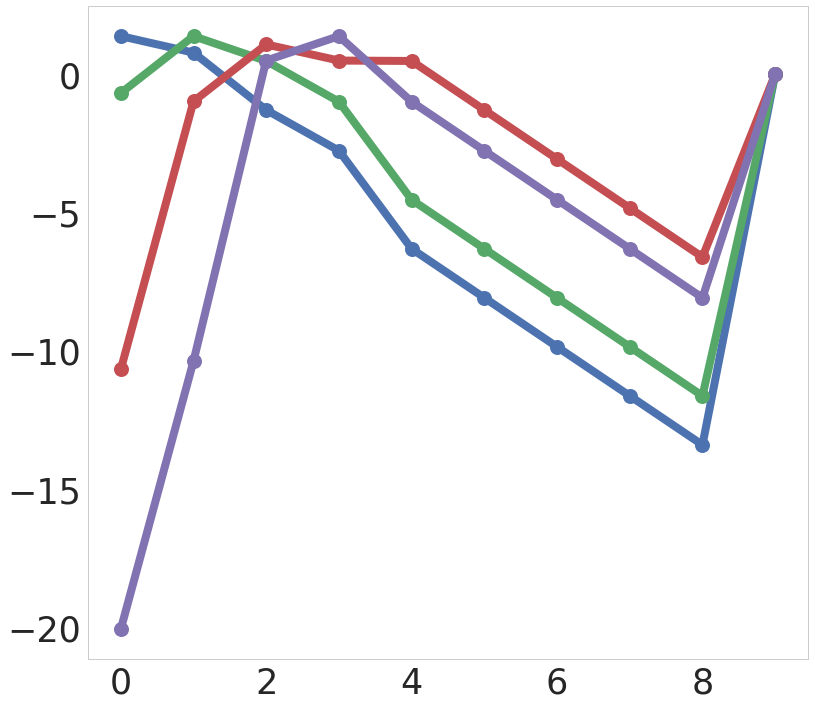

In [44]:
plt.plot(w[:, 0], 'o-', ms=15, lw=8)
plt.plot(w[:, 1], 'o-', ms=15, lw=8)
plt.plot(w[:, 2], 'o-', ms=15, lw=8)
plt.plot(w[:, 3], 'o-', ms=15, lw=8)

In [45]:
timings

[(0, 0.10000000000000001, 0.0, 0.099000000000000005),
 (1, 0.10100000000000001, 0.099000000000000005, 0.19900000000000001),
 (2, 0.16900000000000001, 0.19900000000000001, 0.36699999999999999),
 (3, 0.19800000000000001, 0.36699999999999999, 0.56400000000000006),
 (2, 0.11, 0.56400000000000006, 0.67300000000000004),
 (5, 0.10100000000000001, 0.67300000000000004, 0.77300000000000002),
 (6, 0.10100000000000001, 0.77300000000000002, 0.873),
 (7, 0.10100000000000001, 0.873, 0.97299999999999998),
 (8, 0.10100000000000001, 0.97299999999999998, 1.073),
 (9, 0.46700000000000003, 1.073, 1.5389999999999999)]

In [46]:
T

array([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.10001,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.17129,  0.     ,  0.16732,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.09717,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.10017,  0.     ,  0.     ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.1    ,  0.     ,
         0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.1    ,
         0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
         0.1    ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.   

In [47]:
B = np.zeros((minicolumns, minicolumns))
for i in range(minicolumns):
    for j in range(minicolumns):
        B[i, j] = w[j, j] - w[i, j]

B *= (g_w_ampa / g_a)
transitions = np.copy(B)
transitions[transitions >= 1.0] = 0.0

In [48]:
T_recharge = tau_a * np.log((1 + B[3, 2]) /(1 - B[2, 3]))
T_recharge

0.23711601715924968

In [49]:
B[4, 3]

1.309555615417572

In [50]:
w[3, 3] - w[4, 3]

2.3693624855454485

In [51]:
(g_w_ampa / g_a) * w[3, 3] - w[4, 3]

1.7545819636077888

In [52]:
g_a

1.8092874083777959

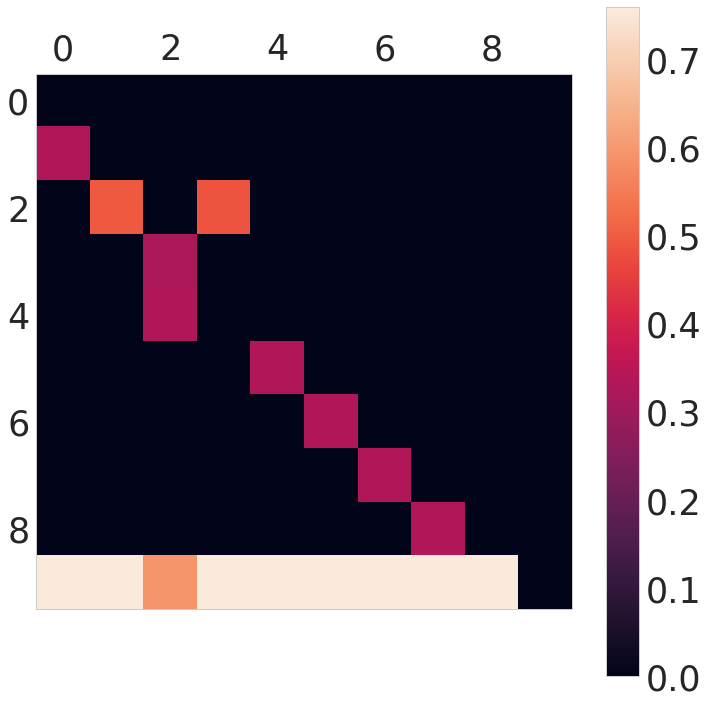

In [53]:
plt.matshow(transitions)
plt.colorbar()

In [54]:
T = tau_a * np.log(1.0 / (1 - transitions))

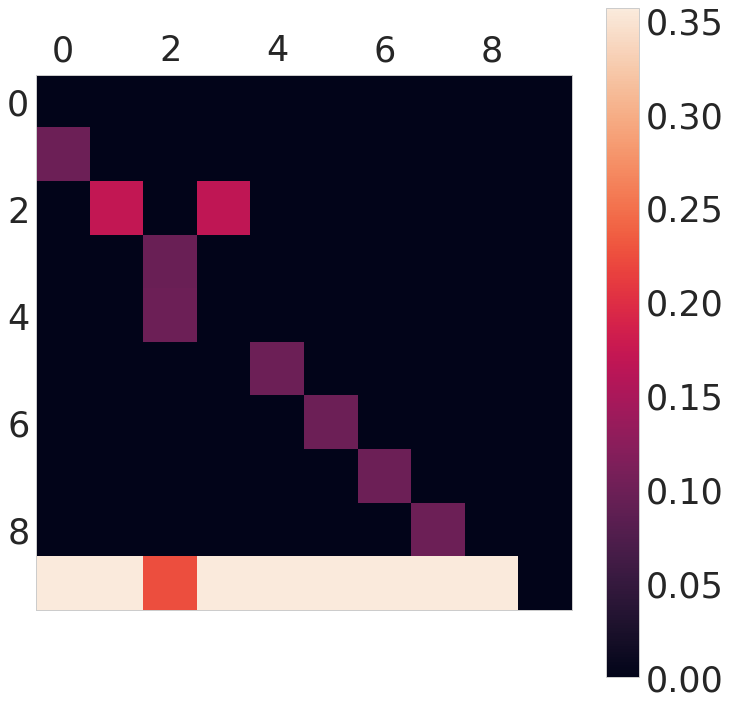

In [55]:
plt.matshow(T)
plt.colorbar()

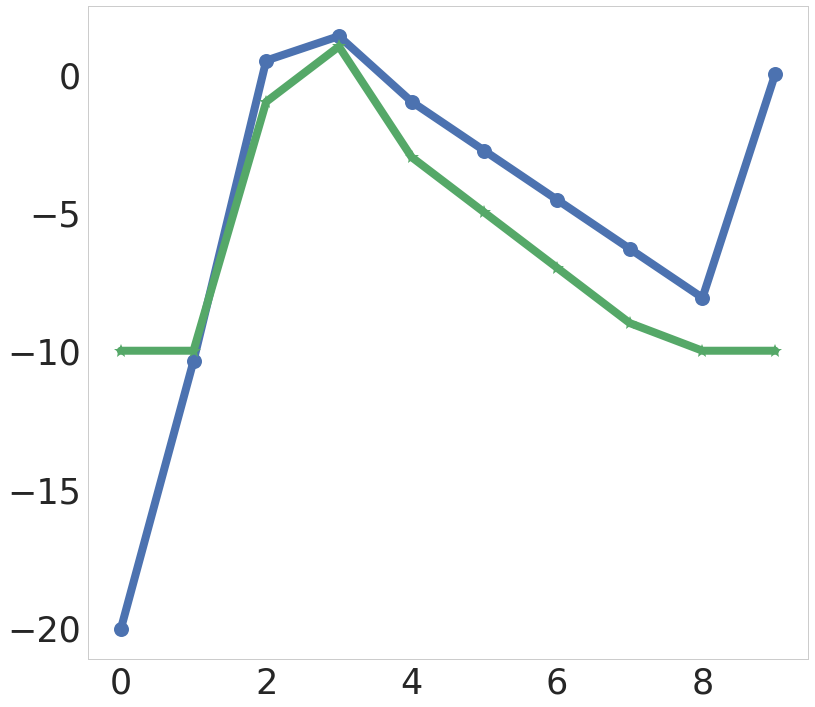

In [60]:
index = 3
plt.plot(w[:, index], 'o-', ms=15, lw=8)
if False:
    plt.plot(w[:, 1], 'o-', ms=15, lw=8)
    plt.plot(w[:, 2], 'o-', ms=15, lw=8)
    plt.plot(w[:, 3], 'o-', ms=15, lw=8)

plt.plot(w_artificial[:, index], '*-', ms=15, lw=8)
if False:
    plt.plot(w_artificial[:, 1], '*-', ms=15, lw=8)
    plt.plot(w_artificial[:, 2], '*-', ms=15, lw=8)
    plt.plot(w_artificial[:, 3], '*-', ms=15, lw=8)

## An example without controlling persistence time

CPU times: user 624 ms, sys: 0 ns, total: 624 ms
Wall time: 627 ms


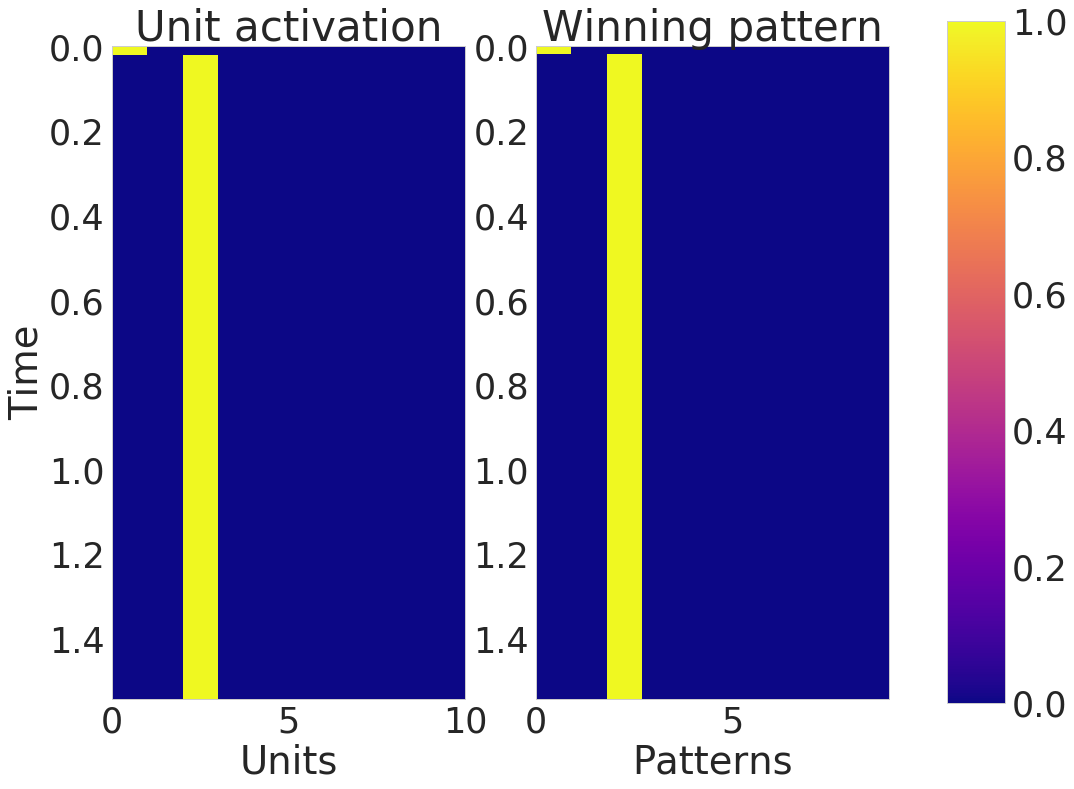

In [149]:
%%time
always_learning = False
strict_maximum = True
perfect = True
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.50
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 1.0
T_cue = 0.020
T_persistence = 0.100
T_recall = T_cue + (1.5) * T_persistence * n_patterns 
if not perfect:
    T_persistence = max(0.005, T_persistence - tau_m)

factor = 0.00

num1 = 3
num2 = 10
training_times_vector = np.linspace(0.050, 1.0, num=num1)
tau_z_vector = np.linspace(0.025, 0.150, num=num2)
success_vector = np.zeros((num1, num2))
B_vector = np.zeros((num1, num2))
T_recharge_vector = np.zeros((num1, num2))
T_jump_vector = np.zeros((num1, num2))
g_a_vector = np.zeros((num1, num2))

# Patterns parameters
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, g_beta=g_beta,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Training
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
seq = np.copy(matrix)
seq[4] = matrix[2]
seq[5:] = matrix[4:-1]

nr = build_network_representation(seq, minicolumns, hypercolumns)
timed_input = TimedInput(nr, dt, training_time, 
                         inter_pulse_interval=inter_pulse_interval, 
                         inter_sequence_interval=inter_sequence_interval, 
                         epochs=epochs, resting_time=resting_time)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
w, beta = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

nn.w_ampa = w
nn.beta = beta

# Fix the persistence time
B = 1 - np.exp(-T_persistence / tau_a)
w_per = w[7, 7] - w[8, 7]
g_a = g_w_ampa * w_per / B
nn.g_a = g_a


w_rob = w[8, 6] - w[6, 6]
current = 2  * g_w_ampa * w_rob
noise = factor * current
nn.sigma = noise

# Dictionary
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
s, timings, pattern_sequence = aux

B = np.zeros((minicolumns, minicolumns))
for i in range(minicolumns):
    for j in range(minicolumns):
        B[i, j] = w[j, j] - w[i, j]

B *= (g_w_ampa / g_a)
transitions = np.copy(B)
transitions[transitions >= 1.0] = 0.0
transitions[transitions <= 0] = 0.0

T = tau_a * np.log(1.0 / (1 - transitions))

T_recharge = tau_a * np.log((1 + B[3, 2]) /(1 - B[2, 3]))
T_jump = T[4, 3]

plot_network_activity_angle(manager)

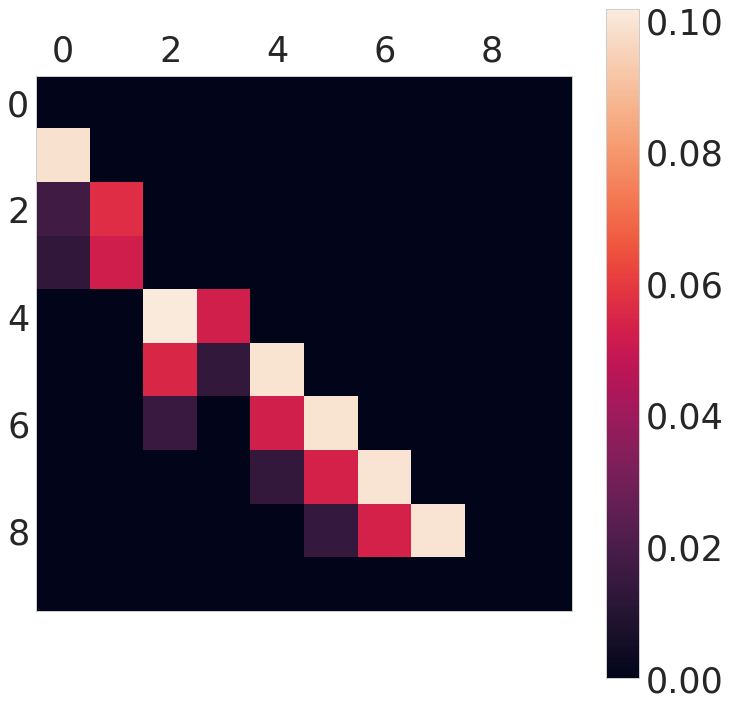

In [154]:
B[B < 0] = 0
effective_B = g_w 
plt.matshow(T)
plt.colorbar()

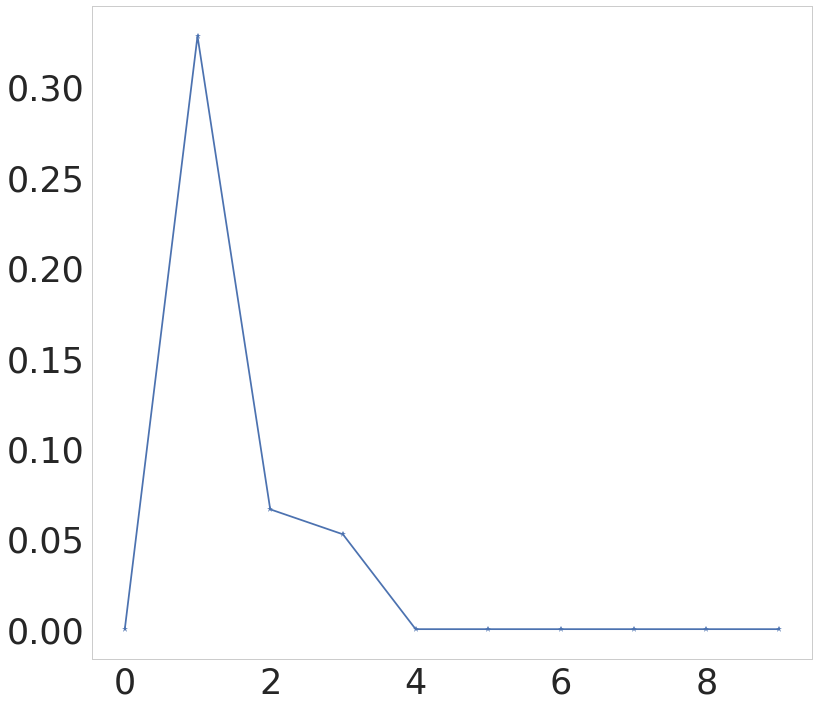

In [153]:
plt.plot(B[:, 0], '*-')

## Systematic

In [131]:
%%time
always_learning = False
strict_maximum = True
perfect = True
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 1.0
T_cue = 0.020
T_persistence = 0.100
T_recall = T_cue + (1.5) * T_persistence * n_patterns 
if not perfect:
    T_persistence = max(0.005, T_persistence - tau_m)

factor = 0.00

num1 = 3
num2 = 10
training_times_vector = np.linspace(0.050, 1.0, num=num1)
tau_z_vector = np.linspace(0.025, 0.150, num=num2)
success_vector = np.zeros((num1, num2))
B_vector = np.zeros((num1, num2))
T_recharge_vector = np.zeros((num1, num2))
T_jump_vector = np.zeros((num1, num2))
g_a_vector = np.zeros((num1, num2))

for training_index, training_time in enumerate(training_times_vector):
    for tau_index, tau_z_pre_ampa in enumerate(tau_z_vector):

        # Patterns parameters
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, g_beta=g_beta,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                          perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                          normalized_currents=normalized_currents)

        # Training
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
        seq = np.copy(matrix)
        seq[4] = matrix[2]
        seq[5:] = matrix[4:-1]

        nr = build_network_representation(seq, minicolumns, hypercolumns)
        timed_input = TimedInput(nr, dt, training_time, 
                                 inter_pulse_interval=inter_pulse_interval, 
                                 inter_sequence_interval=inter_sequence_interval, 
                                 epochs=epochs, resting_time=resting_time)

        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        S = timed_input.build_timed_input()
        z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
        z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

        pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
        w, beta = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

        nn.w_ampa = w
        nn.beta = beta

        # Fix the persistence time
        B = 1 - np.exp(-T_persistence / tau_a)
        w_per = w[7, 7] - w[8, 7]
        g_a = g_w_ampa * w_per / B
        nn.g_a = g_a


        w_rob = w[8, 6] - w[6, 6]
        current = 2  * g_w_ampa * w_rob
        noise = factor * current
        nn.sigma = noise

        # Dictionary
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        manager.patterns_dic = patterns_dic

        aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
        s, timings, pattern_sequence = aux

        B = np.zeros((minicolumns, minicolumns))
        for i in range(minicolumns):
            for j in range(minicolumns):
                B[i, j] = w[j, j] - w[i, j]

        B *= (g_w_ampa / g_a)
        transitions = np.copy(B)
        transitions[transitions >= 1.0] = 0.0

        T = tau_a * np.log(1.0 / (1 - transitions))

        T_recharge = tau_a * np.log((1 + B[3, 2]) /(1 - B[2, 3]))
        T_jump = T[4, 3]
        
        success_vector[training_index, tau_index] = s
        T_recharge_vector[training_index, tau_index] = T_recharge
        T_jump_vector[training_index, tau_index] = T_jump
        g_a_vector[training_index, tau_index] = g_a
        B_vector[training_index, tau_index] = B[4, 3]

/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:122: RuntimeWarning: invalid value encountered in log


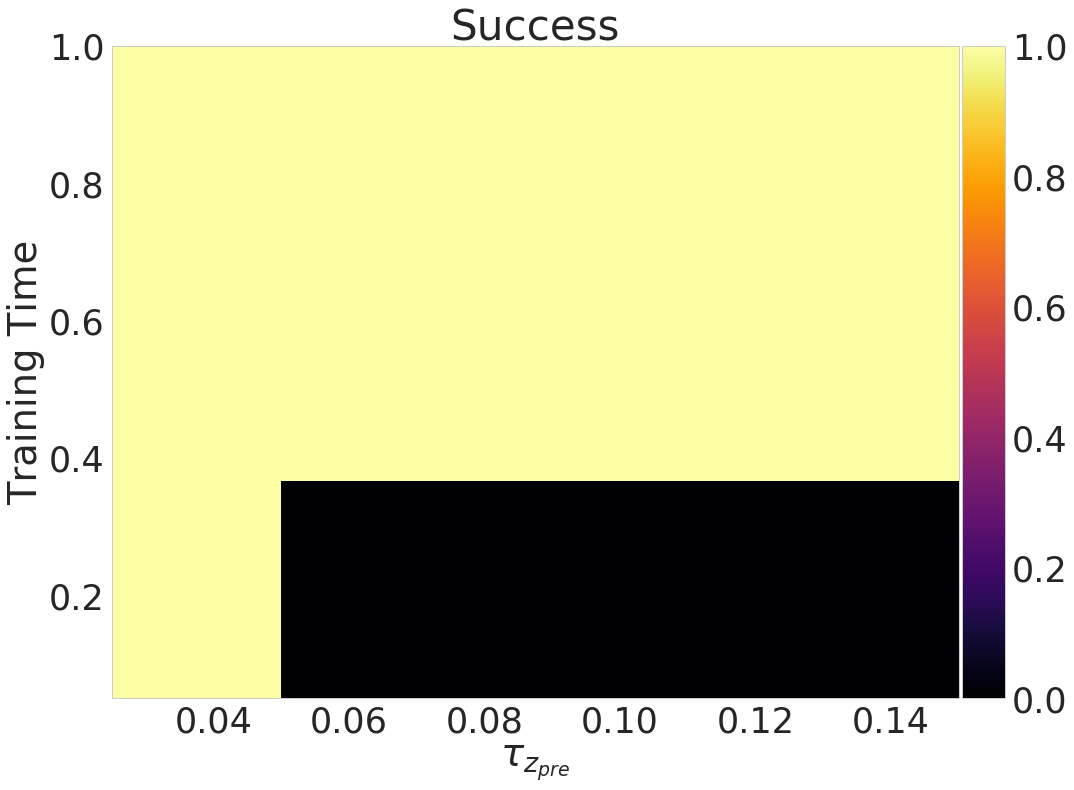

In [132]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_vector[0], tau_z_vector[-1], training_times_vector[0], training_times_vector[-1]]

im = ax.imshow(success_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel(r'Training Time')
ax.set_title(r'Success');

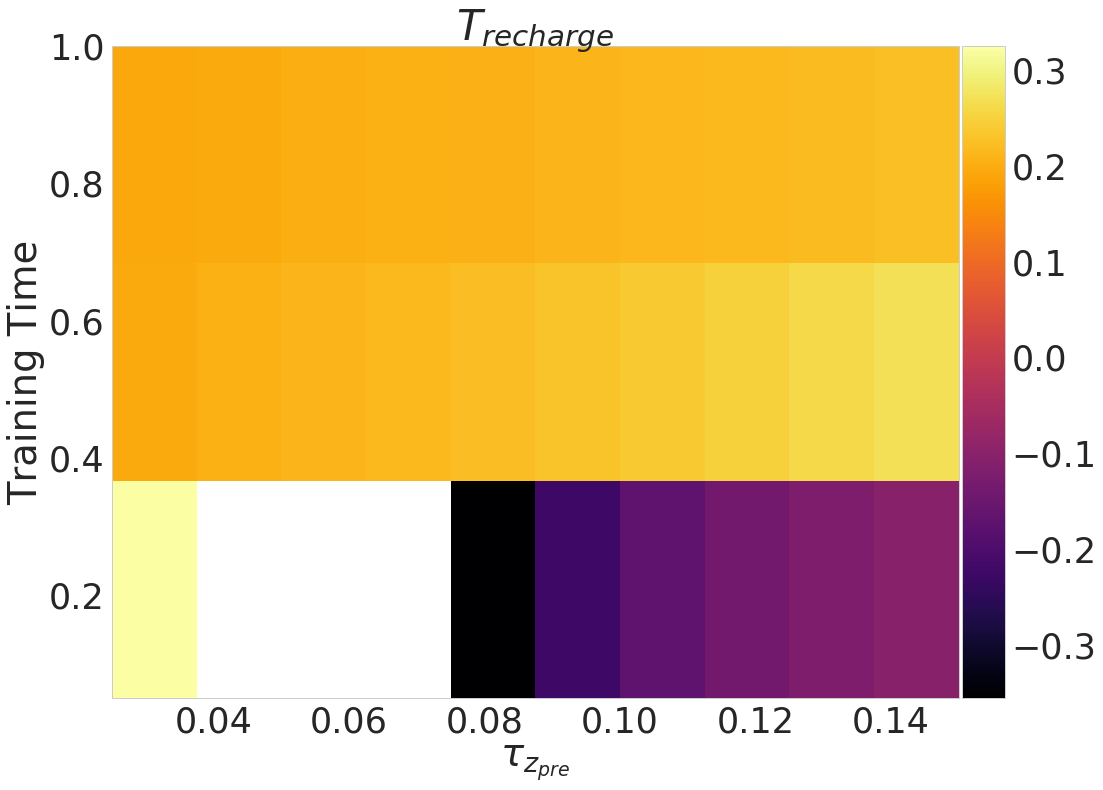

In [133]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_vector[0], tau_z_vector[-1], training_times_vector[0], training_times_vector[-1]]

im = ax.imshow(T_recharge_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel(r'Training Time')
ax.set_title(r'$T_{recharge}$');

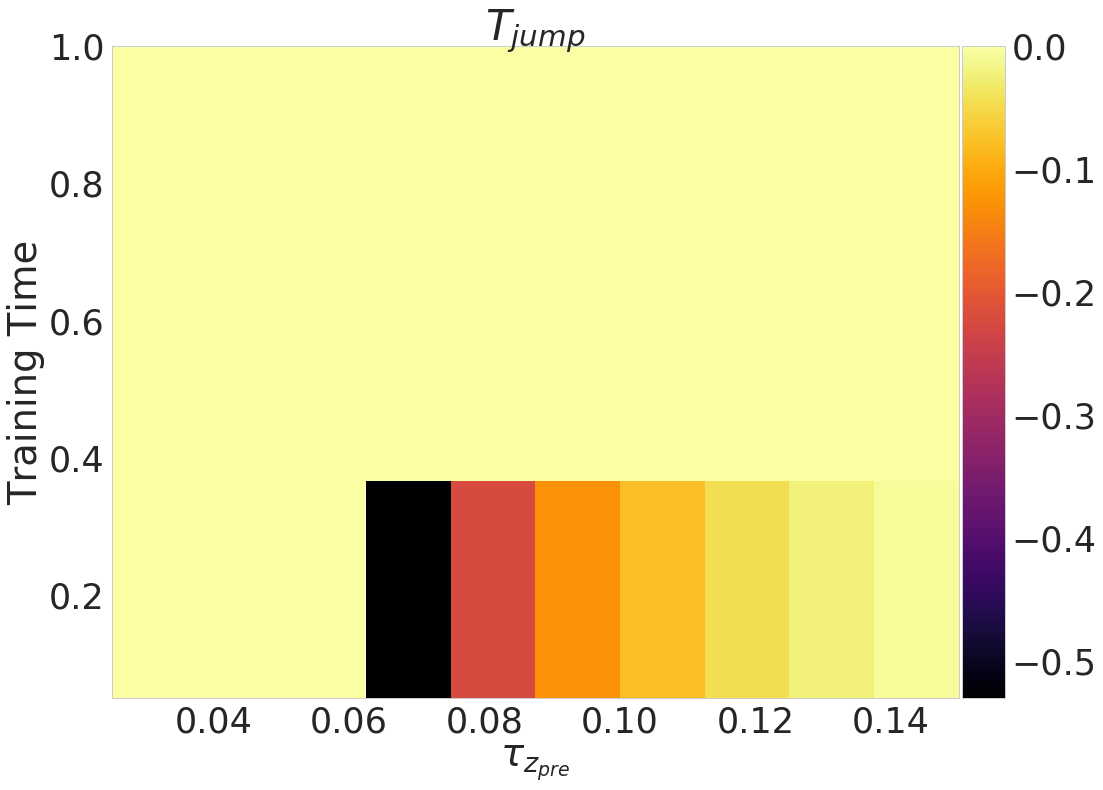

In [134]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_vector[0], tau_z_vector[-1], training_times_vector[0], training_times_vector[-1]]

im = ax.imshow(T_jump_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel(r'Training Time')
ax.set_title(r'$T_{jump}$');

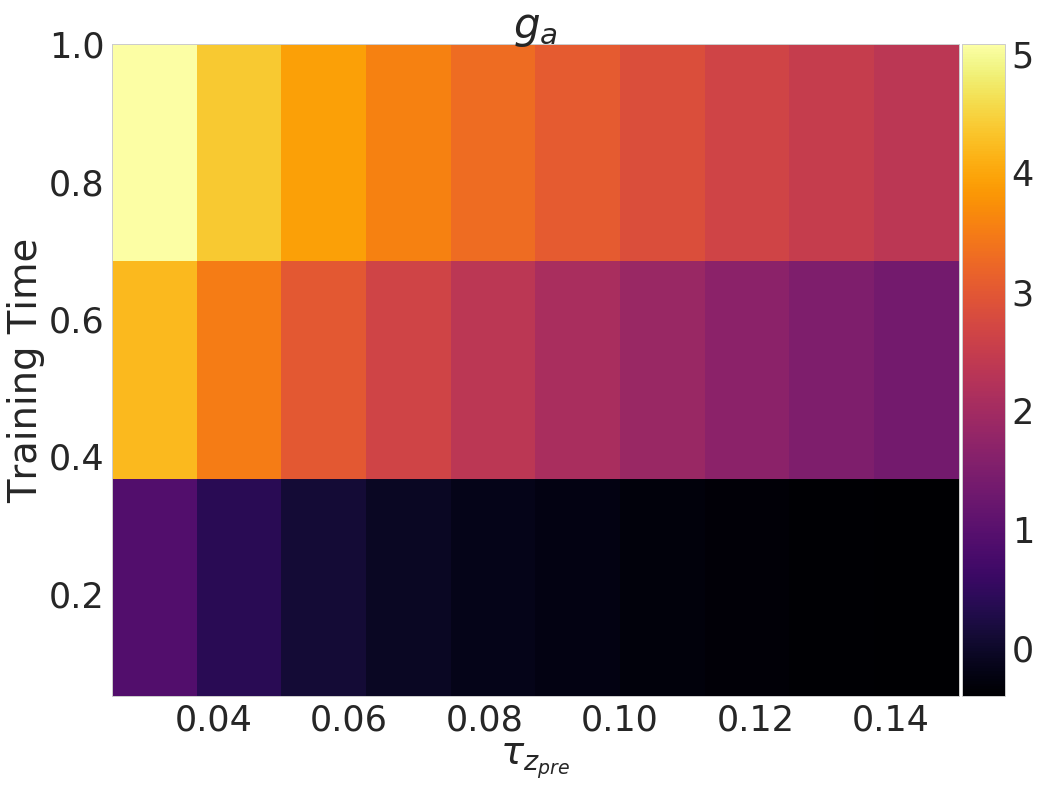

In [135]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_vector[0], tau_z_vector[-1], training_times_vector[0], training_times_vector[-1]]

im = ax.imshow(g_a_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel(r'Training Time')
ax.set_title(r'$g_{a}$');

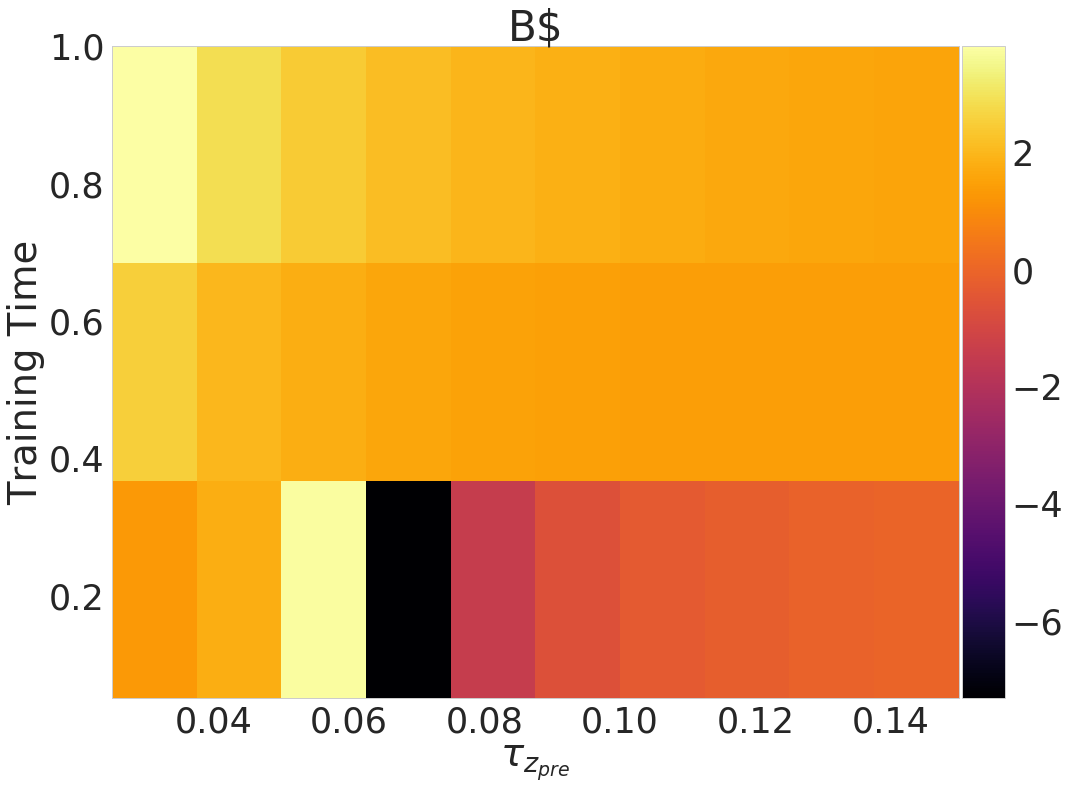

In [136]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_vector[0], tau_z_vector[-1], training_times_vector[0], training_times_vector[-1]]

im = ax.imshow(B_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel(r'Training Time')
ax.set_title(r'B');

## Non-control of T_persistence

In [155]:
%%time
always_learning = False
strict_maximum = True
perfect = True
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 5.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 1.0
T_cue = 0.020
T_persistence = 0.100
T_recall = 2.0

factor = 0.00

num1 = 3
num2 = 10
training_times_vector = np.linspace(0.050, 1.0, num=num1)
tau_z_vector = np.linspace(0.025, 0.150, num=num2)
success_vector = np.zeros((num1, num2))
B_vector = np.zeros((num1, num2))
T_recharge_vector = np.zeros((num1, num2))
T_jump_vector = np.zeros((num1, num2))
g_a_vector = np.zeros((num1, num2))

for training_index, training_time in enumerate(training_times_vector):
    for tau_index, tau_z_pre_ampa in enumerate(tau_z_vector):

        # Patterns parameters
        nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, g_beta=g_beta,
                          sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                          z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                          perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                          normalized_currents=normalized_currents)

        # Training
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
        seq = np.copy(matrix)
        seq[4] = matrix[2]
        seq[5:] = matrix[4:-1]

        nr = build_network_representation(seq, minicolumns, hypercolumns)
        timed_input = TimedInput(nr, dt, training_time, 
                                 inter_pulse_interval=inter_pulse_interval, 
                                 inter_sequence_interval=inter_sequence_interval, 
                                 epochs=epochs, resting_time=resting_time)

        # Build the manager
        manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

        S = timed_input.build_timed_input()
        z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
        z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

        pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
        w, beta = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

        nn.w_ampa = w
        nn.beta = beta

        # Fix the persistence time
        w_rob = w[8, 6] - w[6, 6]
        current = 2  * g_w_ampa * w_rob
        noise = factor * current
        nn.sigma = noise

        # Dictionary
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        manager.patterns_dic = patterns_dic

        aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
        s, timings, pattern_sequence = aux

        B = np.zeros((minicolumns, minicolumns))
        for i in range(minicolumns):
            for j in range(minicolumns):
                B[i, j] = w[j, j] - w[i, j]

        B *= (g_w_ampa / g_a)
        transitions = np.copy(B)
        transitions[transitions >= 1.0] = 0.0

        T = tau_a * np.log(1.0 / (1 - transitions))

        T_recharge = tau_a * np.log((1 + B[3, 2]) /(1 - B[2, 3]))
        T_jump = T[4, 3]
        
        success_vector[training_index, tau_index] = s
        T_recharge_vector[training_index, tau_index] = T_recharge
        T_jump_vector[training_index, tau_index] = T_jump
        g_a_vector[training_index, tau_index] = g_a
        B_vector[training_index, tau_index] = B[4, 3]

CPU times: user 16.1 s, sys: 4 ms, total: 16.1 s
Wall time: 16 s


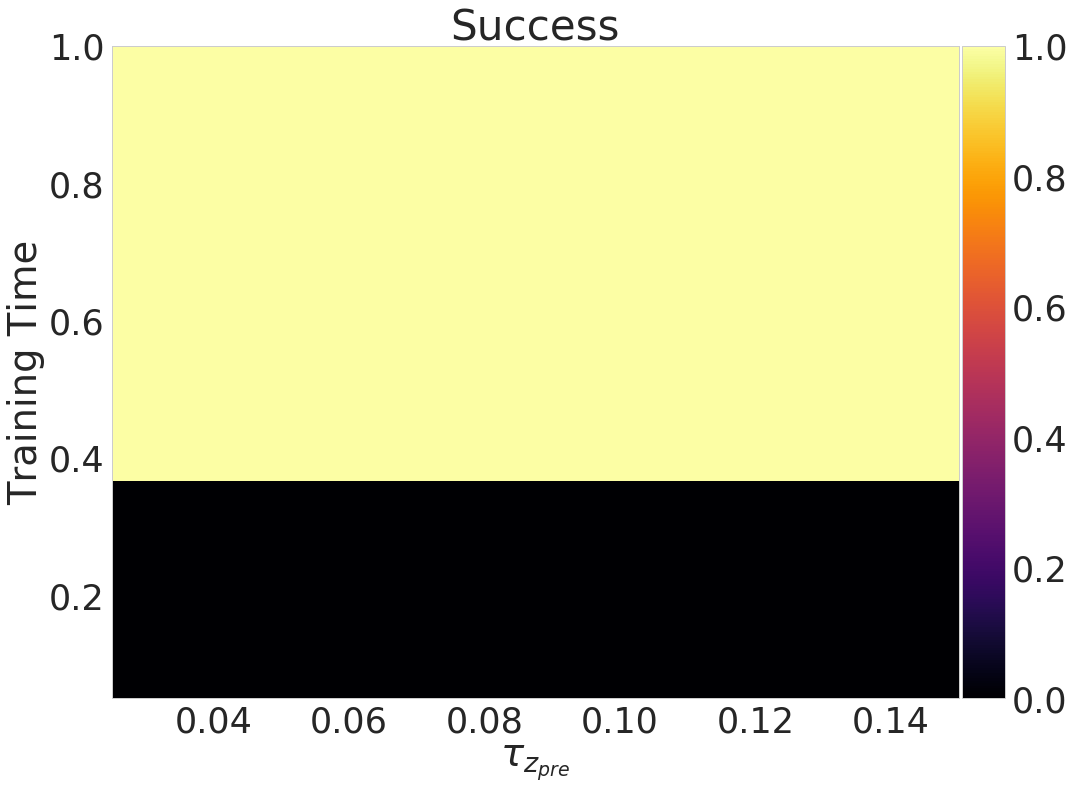

In [156]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_vector[0], tau_z_vector[-1], training_times_vector[0], training_times_vector[-1]]

im = ax.imshow(success_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel(r'Training Time')
ax.set_title(r'Success');

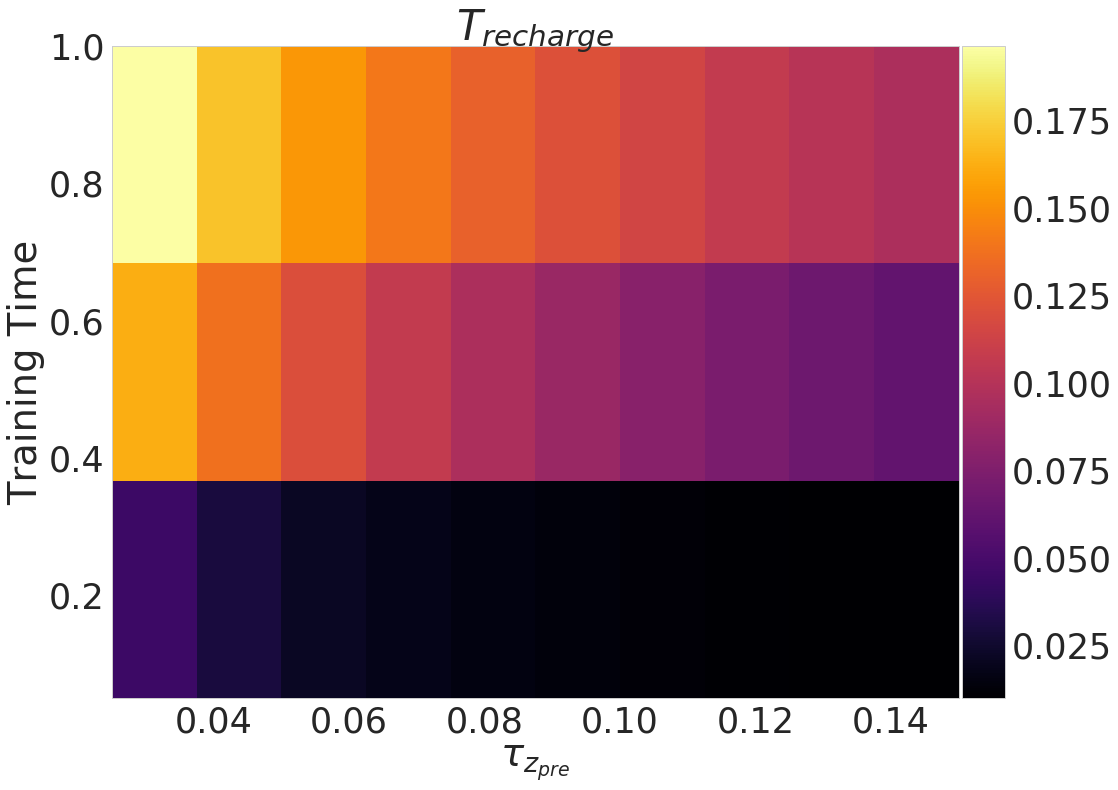

In [157]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cmap = matplotlib.cm.inferno
extent = [tau_z_vector[0], tau_z_vector[-1], training_times_vector[0], training_times_vector[-1]]

im = ax.imshow(T_recharge_vector, cmap=cmap, extent=extent, origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel(r'Training Time')
ax.set_title(r'$T_{recharge}$');